In [1]:
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule

import matplotlib.pyplot as plt

In [38]:
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir='../data_birdset/HSN', # specify your data directory!
        dataset_name='HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sampling_rate=32000,
    ),
)

In [39]:
dm.prepare_data()

One-hot-encoding (num_proc=3):   0%|          | 0/17940 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14352 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3588 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

In [40]:
dm.setup(stage='fit')

In [41]:
train_loader = dm.train_dataloader()

In [42]:
sample = next(iter(train_loader))
img = sample['input_values']
label = sample['labels']

In [43]:
print(f'N, C, H, W: {img.shape}')

N, C, H, W: torch.Size([32, 1, 128, 1024])


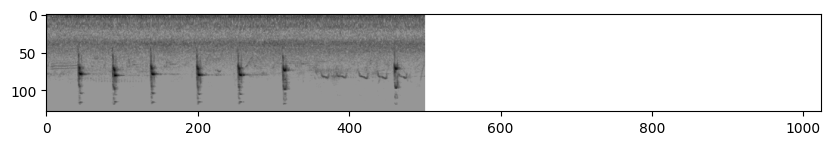

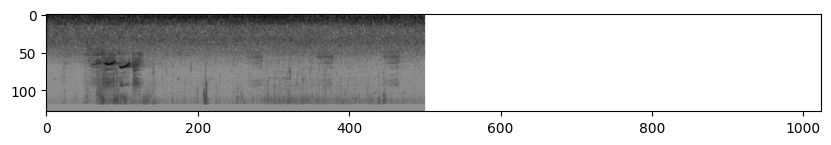

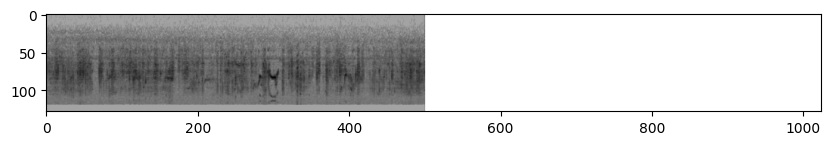

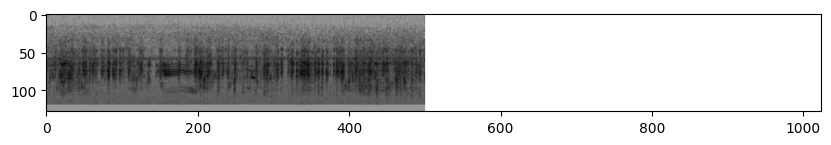

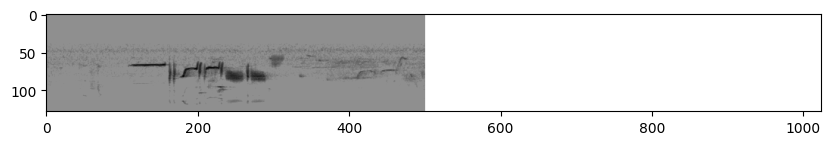

In [44]:
for i in range(5):
    plt.figure(figsize=(10,10))
    plt.imshow(img[-i].permute(1,2,0), cmap='gray')
    plt.show()